# Technical exercise

In [ ]:
import polars as pl

pl.Config.set_tbl_cols(20)

training_df = pl.read_csv("data/trainingset.csv").rename({"CurveCall": "curve_cal"})
validation_df = pl.read_csv("data/validationset.csv")

print(training_df.head())

shape: (5, 9)
┌────────┬───────────┬───────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ id     ┆ cq        ┆ baseline  ┆ plateau  ┆ slope    ┆ inflecti ┆ asymmetr ┆ drift    ┆ curve_ca │
│ ---    ┆ ---       ┆ ---       ┆ ---      ┆ ---      ┆ on       ┆ y        ┆ ---      ┆ l        │
│ i64    ┆ f64       ┆ f64       ┆ f64      ┆ f64      ┆ ---      ┆ ---      ┆ f64      ┆ ---      │
│        ┆           ┆           ┆          ┆          ┆ f64      ┆ f64      ┆          ┆ bool     │
╞════════╪═══════════╪═══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 53369  ┆ 39.381426 ┆ 18.862292 ┆ 35.52776 ┆ -0.44798 ┆ 35.35770 ┆ 5.5      ┆ 0.036513 ┆ true     │
│        ┆           ┆           ┆ 9        ┆ 4        ┆ 7        ┆          ┆          ┆          │
│ 182009 ┆ 26.649803 ┆ 23.902034 ┆ 25.03560 ┆ -0.13896 ┆ 13.67799 ┆ 5.5      ┆ 0.026517 ┆ false    │
│        ┆           ┆           ┆ 2        ┆          ┆ 8        ┆          

### First observations
- Features seem related to the parameters from 5 parameter logistic function (5PL)
  > The five-parameter logistic: A characterization and comparison with the four-parameter logistic, Gottschalk, Dunn 2005, Analytical Biochemistry
  $$
    \displaystyle y = d + \frac{a-d}{(1+(\frac{x}{c})^b)^g}
  $$
  - *a*: plateau
  - *b*: slope
  - *c*: inflection
  - *d*: baseline
  - *g*: asymmetry

  For valid positive qPCR curves we expect following constraints:
  - a > d
  - b < 0
  - c > 0
  - g > 0

  Questions:
  - What is the quality of these fits?
  - Any anomalies that could have thrown off the fit?
  - Noisy data?

- cq

  Questions:
  - How is this computed? Thresholding, based on point of optimal efficiency?

- drift: 

  Questions:
  - Is this the correction done before fitting 5PL?
    

## EDA

Explore and validate

In [10]:
training_df.describe()

statistic,id,cq,baseline,plateau,slope,inflection,asymmetry,drift,curve_cal
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1000.0,819.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
"""null_count""",0.0,181.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",178581.869,37.143438,18.393905,38.119705,-0.456405,34.684044,4.364607,0.037798,0.461
"""std""",124526.06972,9.895221,5.055759,46.755192,0.36063,13.699149,1.875227,0.05005,null
"""min""",11860.0,0.509646,-74.319376,11.26842,-4.56443,0.0,0.5,-0.355829,0.0
"""25%""",55133.0,37.846411,16.262369,23.460999,-0.470736,33.749823,3.236583,0.019663,null
"""50%""",154277.0,38.72126,18.52163,33.922286,-0.42736,34.733139,5.5,0.036072,null
"""75%""",269748.0,40.84914,20.996684,40.236036,-0.317864,44.680086,5.5,0.060586,null
"""max""",455395.0,49.982774,29.108979,741.077662,-0.01,60.0,5.5,0.24413,1.0


Observations:
- Cq: 181 curves no Cq was determined = Negative calling
- inflection: max is 60, which is probably max number of cycles N
- drift: both upwards and downwards, is this data from a single target?

/Users/samme/Documents/private/biocartis/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 57.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/samme/Documents/private/biocartis/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 32.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/samme/Documents/private/biocartis/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 93.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/samme/Documents/private/biocartis/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 48.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warn

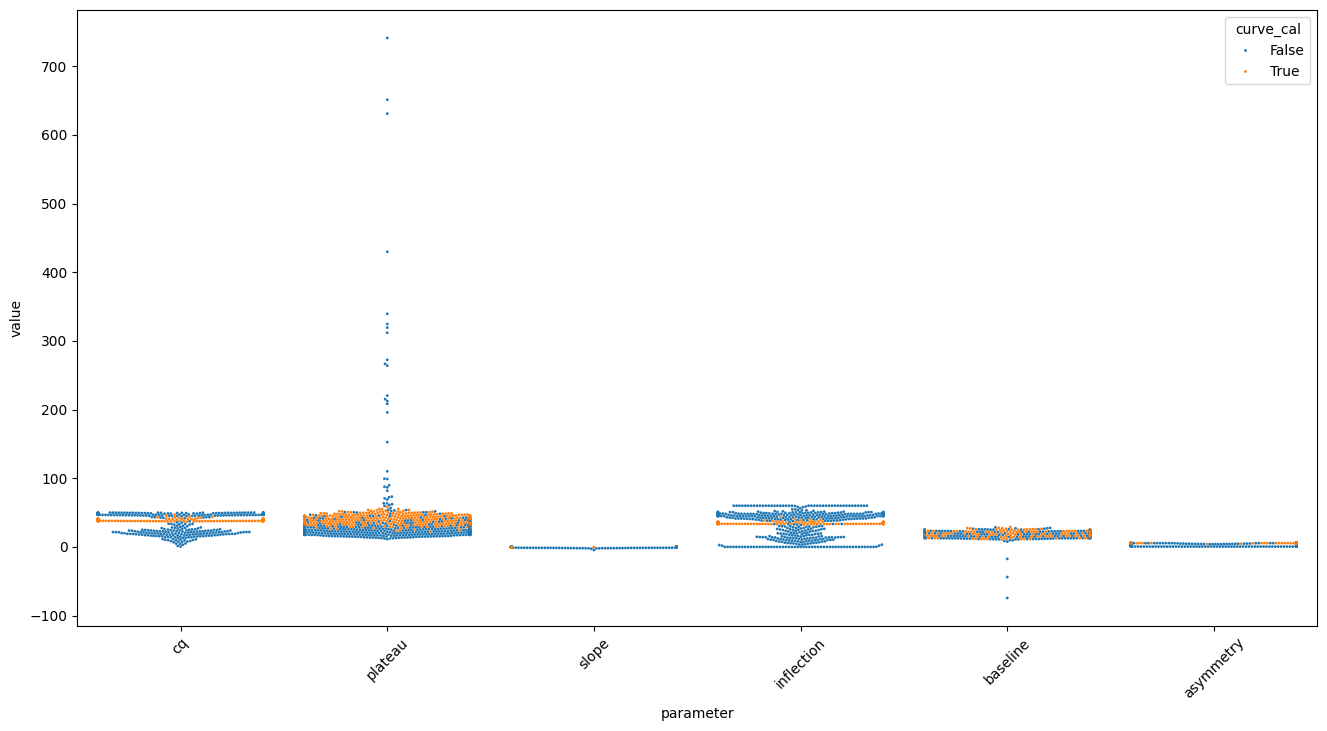

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

training_long = training_df.unpivot(
    on=["cq", "plateau", "slope", "inflection", "baseline", "asymmetry"],
    index=["id", "curve_cal"],
    variable_name="parameter",
    value_name="value",
)

fig, ax = plt.subplots(figsize=(16, 8))
sns.swarmplot(
    data=training_long.to_pandas(),
    x="parameter",
    y="value",
    hue="curve_cal",
    size=2,
    ax=ax,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Observations:
- Lot of variation in plateau: my guess is because of bad quality fits of noisy/anomalous negative curves

Create filter for functional valid qPCR curves

In [ ]:
qpcr_functional_valid_filter = (
    (pl.col("cq") >= 1)
    & pl.col("cq").is_null().not_()
    & (pl.col("baseline") < pl.col("plateau"))
    & (pl.col("inflection") > 0)
    & (pl.col("asymmetry") > 0)
    & (pl.col("slope") < 0)
)
functional_negative_curves = training_df.filter(qpcr_functional_valid_filter.not_())
print(
    f"Number of functional non-positive curves: {functional_negative_curves.shape[0]}"
)

valid_training_df = training_df.filter(qpcr_functional_valid_filter)
print(f"Number of valid curves: {valid_training_df.shape[0]}")

Number of functional non-positive curves: 208
Number of valid curves: 792


/Users/samme/Documents/private/biocartis/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 70.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/samme/Documents/private/biocartis/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/samme/Documents/private/biocartis/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 71.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/x1/m1lp48nn3w9cb10syxpbwcnr0000gp/T/ipykernel_14753/1667354128.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabel

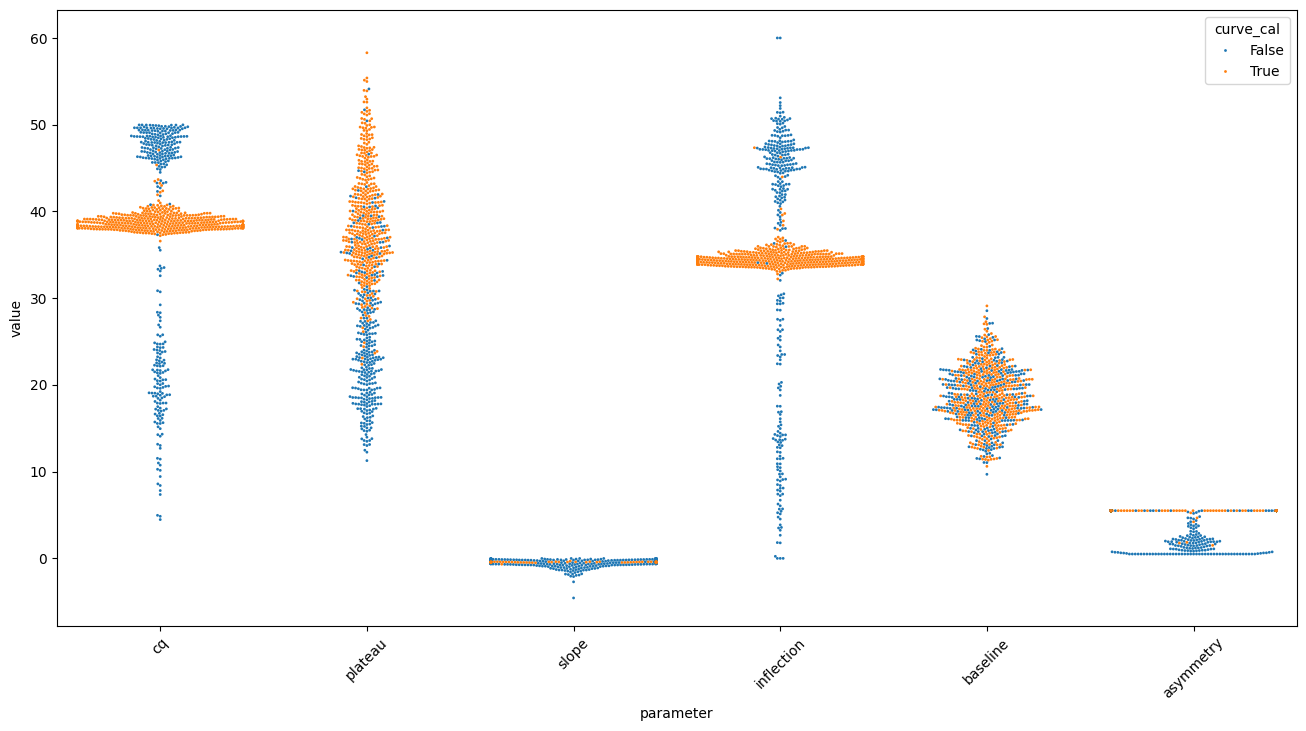

In [19]:
valid_training_long = valid_training_df.unpivot(
    on=["cq", "plateau", "slope", "inflection", "baseline", "asymmetry"],
    index=["id", "curve_cal"],
    variable_name="parameter",
    value_name="value",
)

fig, ax = plt.subplots(figsize=(16, 8))
sns.swarmplot(
    data=valid_training_long.to_pandas(),
    x="parameter",
    y="value",
    hue="curve_cal",
    size=2,
    ax=ax,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

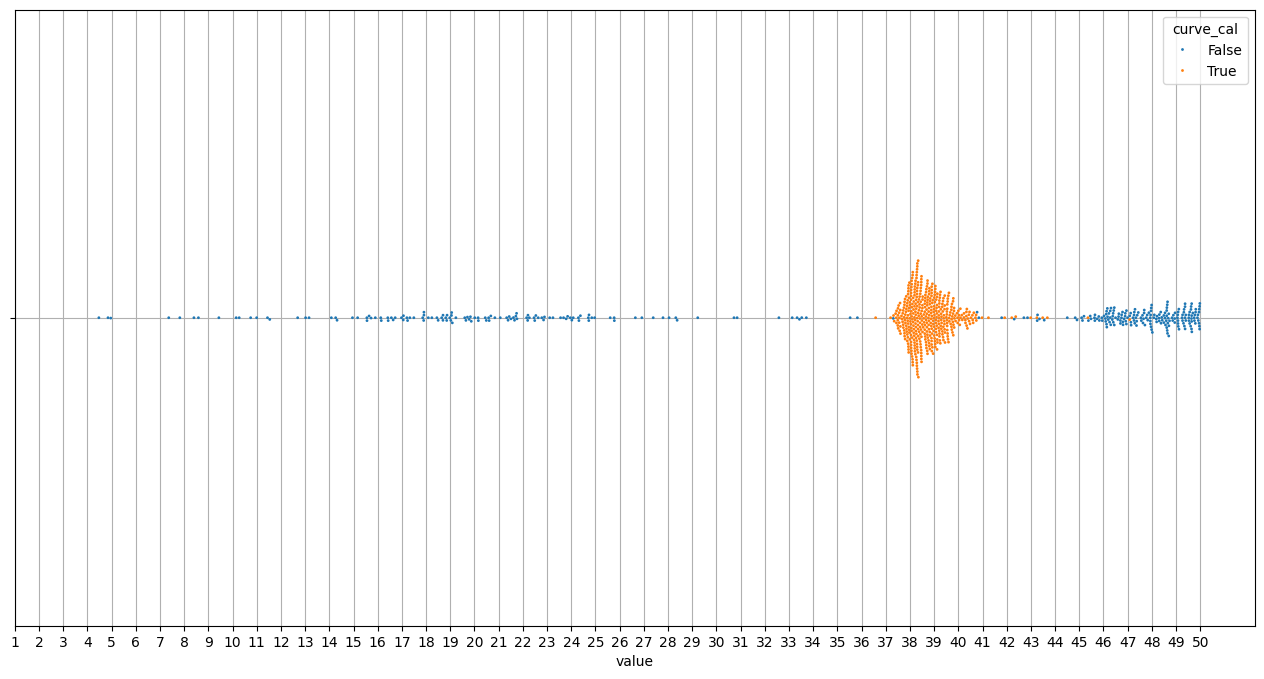

In [ ]:
import numpy as np

fig, ax = plt.subplots(figsize=(16, 8))
sns.swarmplot(
    data=valid_training_long.filter(pl.col("parameter") == "cq").to_pandas(),
    x="value",
    hue="curve_cal",
    size=2,
    ax=ax,
)
ax.set_xticks(np.arange(50) + 1)
ax.grid(True)
plt.show()

Observations:
- Cq
  - majority of positive curves have Cq <= 41
  - some possible low positives between Cq 41 and 44 (correlation with late inflection?)
  - some possible FP above Cq 44


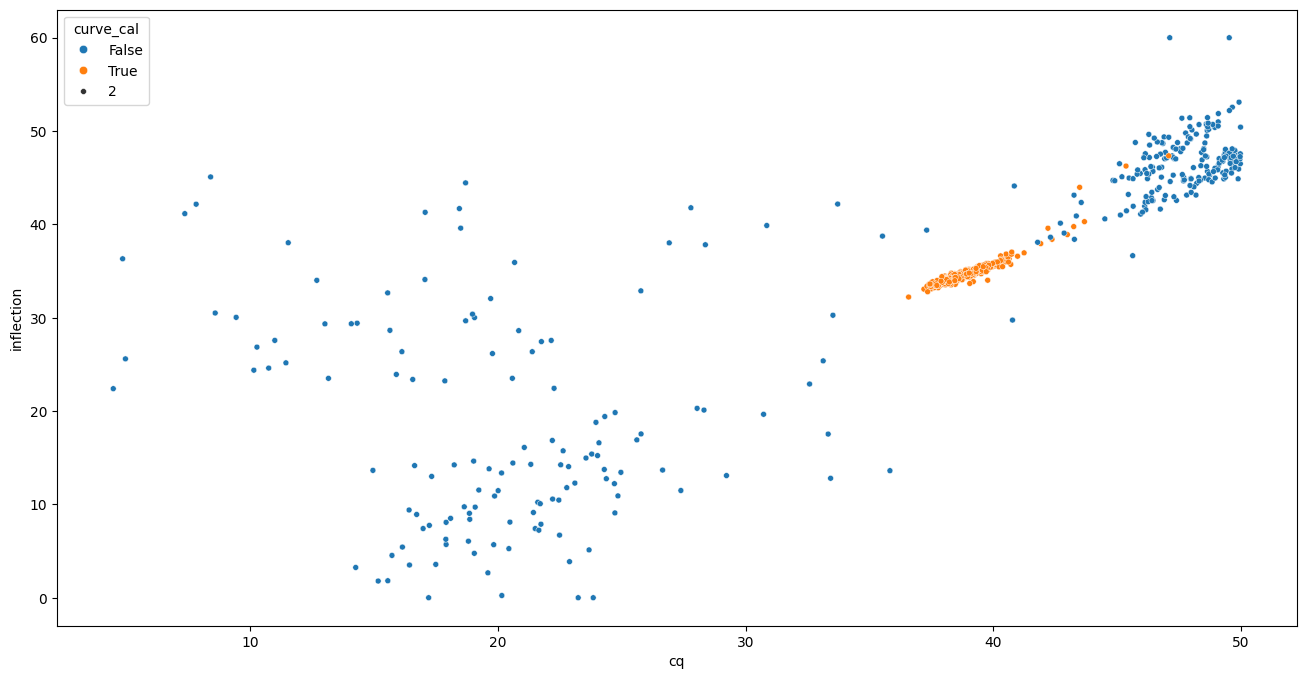

In [30]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(
    data=valid_training_df.select(["cq", "inflection", "curve_cal"]).to_pandas(),
    x="cq",
    y="inflection",
    hue="curve_cal",
    size=2,
    ax=ax,
)
plt.show()

Observations:
- Low positives can be difficult be captured by ML model, but the other parameters might help to differentiate. Expect possibly lower specificity (more FP).

Evaluate 5PL to recreate curves

$$
\displaystyle y = d + \frac{a-d}{(1+(\frac{x}{c})^b)^g}
$$

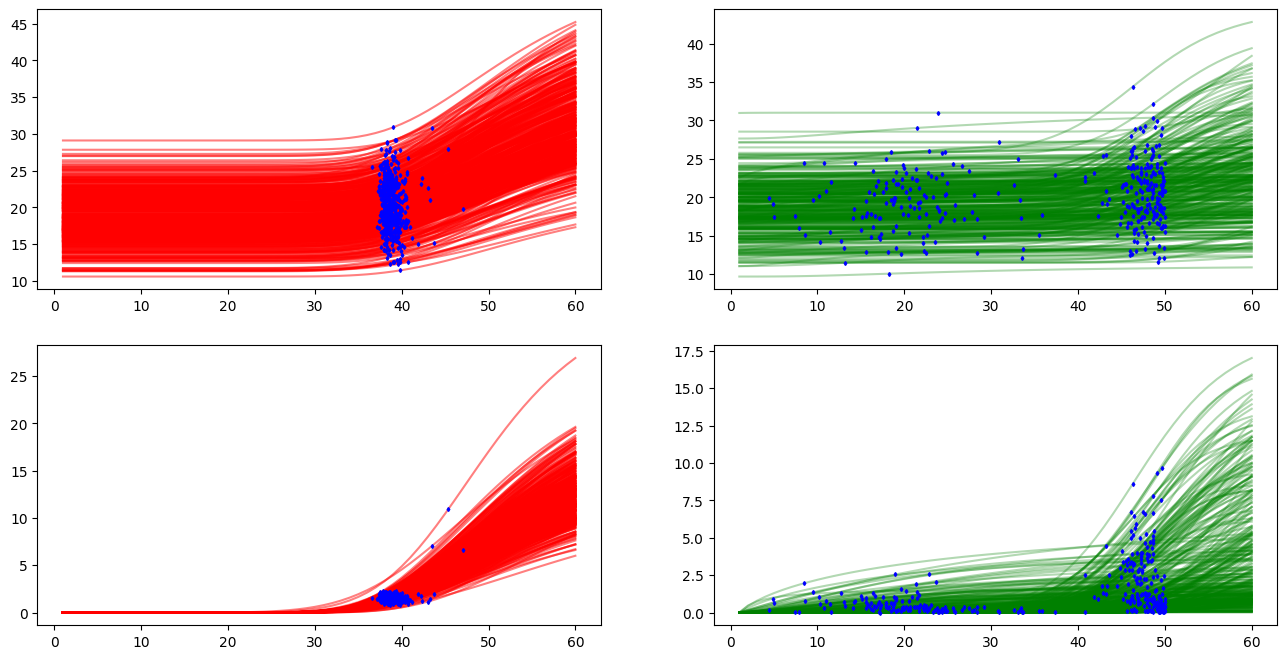

In [100]:
# to numpy arrays for 5PL plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

a = valid_training_df.select("plateau").to_numpy()
b = valid_training_df.select("slope").to_numpy() * 10
c = valid_training_df.select("inflection").to_numpy()
d = valid_training_df.select("baseline").to_numpy()
g = valid_training_df.select("asymmetry").to_numpy()
cq = valid_training_df.select("cq").to_numpy().flatten()
calling = valid_training_df.select("curve_cal").to_numpy().flatten()

N = 60
cycles = np.arange(N) + 1

# 5PL
curves = d + ((a - d) / np.power(1 + np.power(cycles[None, :] / c, b), g))
cqf = np.array(
    [
        np.interp(cqi, cycles, curve) if not np.isnan(cqi) else np.nan
        for cqi, curve in zip(cq, curves)
    ]
)

fig, ((ax_pos, ax_neg), (ax_pos_bc, ax_neg_bc)) = plt.subplots(2, 2, figsize=(16, 8))
ax_pos.plot(cycles, curves[calling == True].T, "r-", alpha=0.5)
ax_neg.plot(cycles, curves[calling == False].T, "g-", alpha=0.3)
ax_pos_bc.plot(
    cycles, (curves - curves.min(axis=1)[:, None])[calling == True].T, "r-", alpha=0.5
)
ax_neg_bc.plot(
    cycles, (curves - curves.min(axis=1)[:, None])[calling == False].T, "g-", alpha=0.3
)
ax_pos.plot(cq[calling == True], cqf[calling == True], "bd", markersize=2)
ax_neg.plot(cq[calling == False], cqf[calling == False], "bd", markersize=2)
ax_pos_bc.plot(
    cq[calling == True], (cqf - curves.min(axis=1))[calling == True], "bd", markersize=2
)
ax_neg_bc.plot(
    cq[calling == False],
    (cqf - curves.min(axis=1))[calling == False],
    "bd",
    markersize=2,
)

Observations:
- slope parameter seems to be scaled? I assumed 10 fold, but probably higher to clearly reflect a sigmoidal shape


## Model training
For machine learning models it is important to clearly define the scope in which the model can operate. Therefore, I only train on valid qpcr curves, rest is negative by definition.

### Feature engineering
I'll reduce the dimensions of the features by computing the delta between plateau and baseline (deltaRn equivalent, but because I can't trust the slope parameter, I will not compute the assymptotes)

In [133]:
valid_training_df = valid_training_df.with_columns(
    delta=pl.col("plateau") - pl.col("baseline")
)

X_df = valid_training_df.select(
    pls.exclude(
        "id", "curve_cal", "baseline", "plateau", "label", pls.starts_with("predicted")
    )
)
X = X_df.to_numpy()
y = valid_training_df.select("curve_cal").to_numpy().flatten()
X_df.head()

cq,slope,inflection,asymmetry,drift,delta
f64,f64,f64,f64,f64,f64
39.381426,-0.447984,35.357707,5.5,0.036513,16.665477
26.649803,-0.13896,13.677998,5.5,0.026517,1.133568
38.08884,-0.429194,33.888961,5.5,0.043123,18.526184
38.118073,-0.412705,33.75039,5.5,-0.017076,19.949547
38.412099,-0.44267,34.340077,5.5,-0.002722,14.142846


Start with simple logistic regression

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import polars.selectors as pls

pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("logreg", LogisticRegression(max_iter=10000, random_state=0)),
    ]
)
logreg_model = pipeline.fit(X, y)
predicted_calling = logreg_model.predict(X)
predicted_proba = logreg_model.predict_proba(X)

print(f"Accuracy: {logreg_model.score(X, y)}")

predicted_valid_training_df = valid_training_df.with_columns(
    predicted_calling_logreg=pl.Series(predicted_calling).cast(pl.Boolean),
    predicted_proba_logreg=pl.Series(predicted_proba[:, 1]),
).with_columns(
    label=pl.when(
        (pl.col("curve_cal") == True) & (pl.col("predicted_calling_logreg") == True)
    )
    .then(pl.lit("TP"))
    .when((pl.col("curve_cal") == True) & (pl.col("predicted_calling_logreg") == False))
    .then(pl.lit("FN"))
    .when((pl.col("curve_cal") == False) & (pl.col("predicted_calling_logreg") == True))
    .then(pl.lit("FP"))
    .when(
        (pl.col("curve_cal") == False) & (pl.col("predicted_calling_logreg") == False)
    )
    .then(pl.lit("TN"))
    .otherwise(pl.lit(""))
)

print(predicted_valid_training_df["label"].value_counts())

Accuracy: 0.9457070707070707
shape: (4, 2)
┌───────┬───────┐
│ label ┆ count │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ TP    ┆ 459   │
│ FN    ┆ 2     │
│ FP    ┆ 41    │
│ TN    ┆ 290   │
└───────┴───────┘


/Users/samme/Documents/private/biocartis/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/samme/Documents/private/biocartis/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 74.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/samme/Documents/private/biocartis/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/samme/Documents/private/biocartis/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 73.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warni

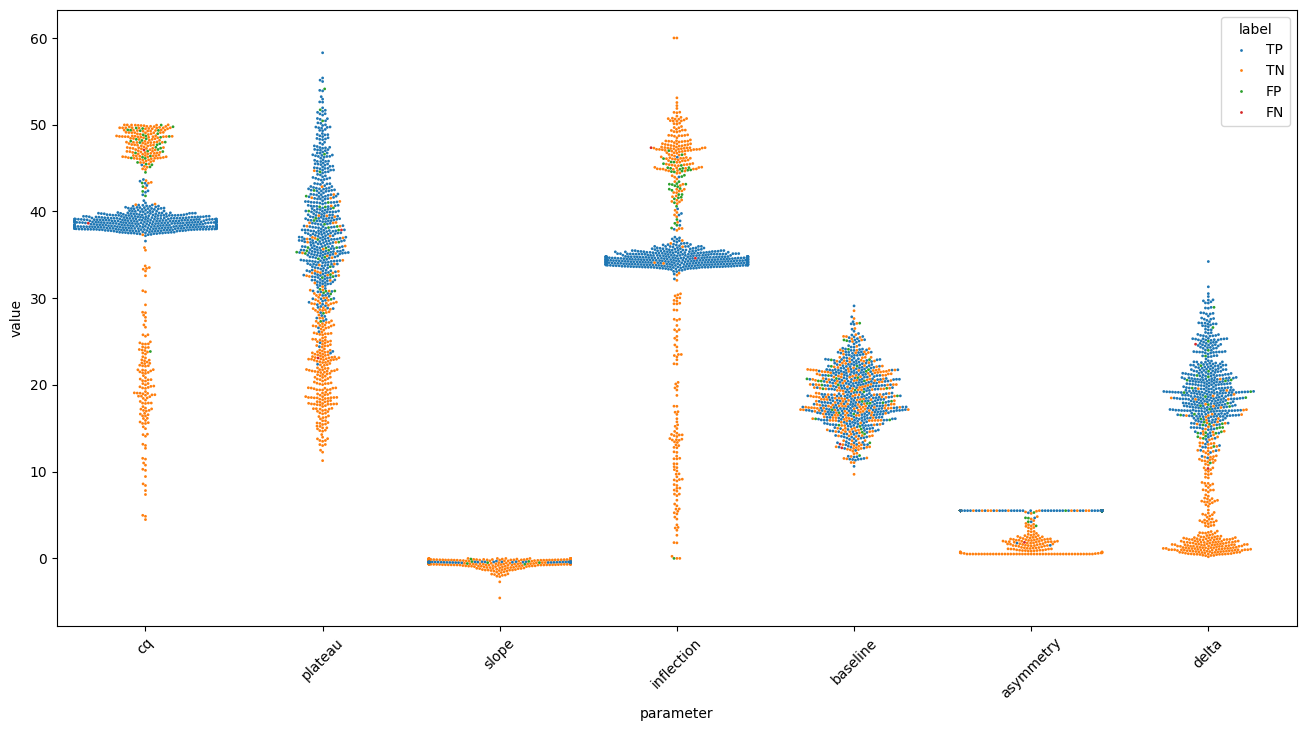

In [140]:
valid_training_long = predicted_valid_training_df.unpivot(
    on=["cq", "plateau", "slope", "inflection", "baseline", "asymmetry", "delta"],
    index=["id", "label"],
    variable_name="parameter",
    value_name="value",
)

fig, ax = plt.subplots(figsize=(16, 8))
sns.swarmplot(
    data=valid_training_long.to_pandas(),
    x="parameter",
    y="value",
    hue="label",
    size=2,
    ax=ax,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

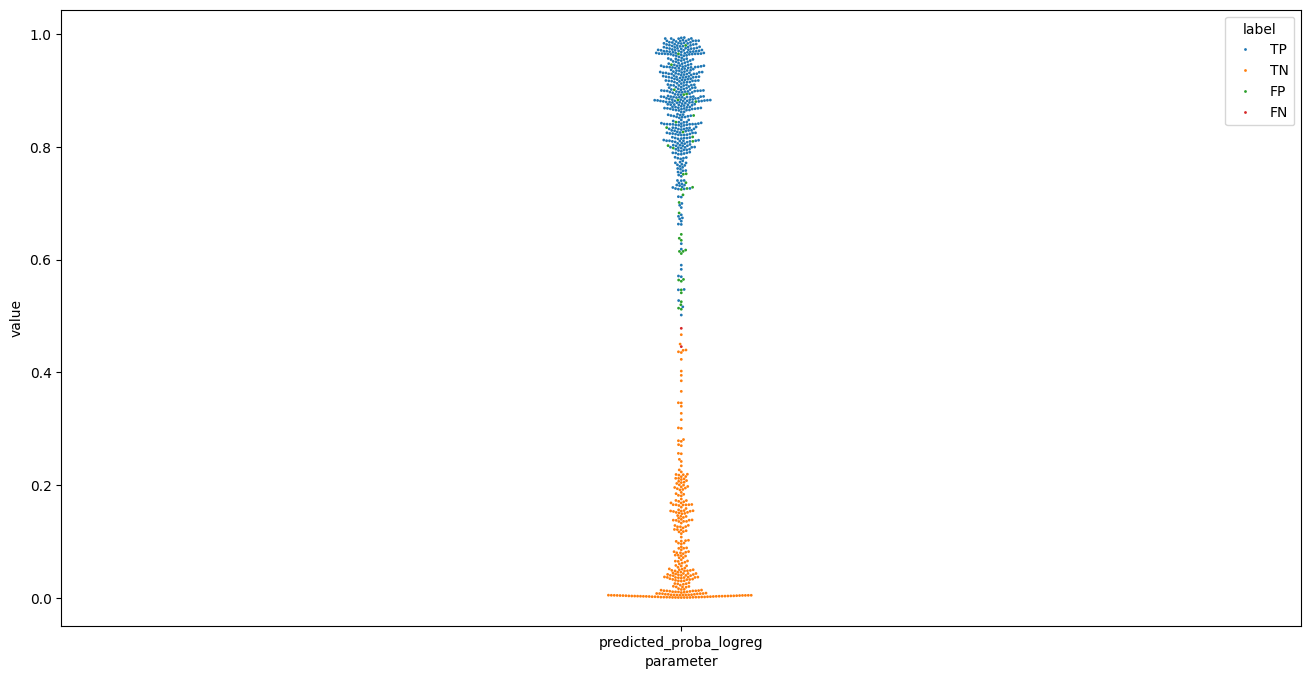

In [141]:
valid_training_long = valid_training_df.unpivot(
    on=["predicted_proba_logreg"],
    index=["id", "label"],
    variable_name="parameter",
    value_name="value",
)

fig, ax = plt.subplots(figsize=(16, 8))
sns.swarmplot(
    data=valid_training_long.to_pandas(),
    x="parameter",
    y="value",
    hue="label",
    size=2,
    ax=ax,
)
plt.show()

Observations:
- Accuracy is 0.9457, still low specificity (FN: 2, FP: 41)
- More FP than FN as expected due to possible low positives in dataset.
- Possibility to set Cq cutoff (manual at 44 for now)


In [ ]:
with_cutoff_predicted_valid_training_df = predicted_valid_training_df.with_columns(
    predicted_calling_logreg=pl.when(pl.col("cq") > 44)
    .then(pl.lit(False))
    .otherwise(pl.col("predicted_calling_logreg")),
).with_columns(
    label=pl.when(
        (pl.col("curve_cal") == True) & (pl.col("predicted_calling_logreg") == True)
    )
    .then(pl.lit("TP"))
    .when((pl.col("curve_cal") == True) & (pl.col("predicted_calling_logreg") == False))
    .then(pl.lit("FN"))
    .when((pl.col("curve_cal") == False) & (pl.col("predicted_calling_logreg") == True))
    .then(pl.lit("FP"))
    .when(
        (pl.col("curve_cal") == False) & (pl.col("predicted_calling_logreg") == False)
    )
    .then(pl.lit("TN"))
    .otherwise(pl.lit(""))
)
accuracy = (
    with_cutoff_predicted_valid_training_df.filter(
        pl.col("label").is_in(["TP", "TN"])
    ).shape[0]
    / with_cutoff_predicted_valid_training_df.shape[0]
)
print(f"Accuracy: {accuracy}")
print(with_cutoff_predicted_valid_training_df["label"].value_counts())

Accuracy: 0.98989898989899
shape: (4, 2)
┌───────┬───────┐
│ label ┆ count │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ TP    ┆ 458   │
│ FN    ┆ 3     │
│ FP    ┆ 5     │
│ TN    ┆ 326   │
└───────┴───────┘


Observations:
- Cq cutoff at 44 increases accuracy to about 0.99
- This is only the set with valid qPCR curves, calculate the actual accuracy

In [151]:
with_cutoff_predicted_valid_training_df.columns

['id',
 'cq',
 'baseline',
 'plateau',
 'slope',
 'inflection',
 'asymmetry',
 'drift',
 'curve_cal',
 'delta',
 'predicted_calling_logreg',
 'label',
 'predicted_proba_logreg']

In [ ]:
total_predicted_training_df = pl.concat(
    [
        functional_negative_curves.with_columns(predicted_calling_logreg=pl.lit(False)),
        with_cutoff_predicted_valid_training_df.select(
            pls.exclude("label", "predicted_proba_logreg", "delta")
        ),
    ]
).with_columns(
    label=pl.when(
        (pl.col("curve_cal") == True) & (pl.col("predicted_calling_logreg") == True)
    )
    .then(pl.lit("TP"))
    .when((pl.col("curve_cal") == True) & (pl.col("predicted_calling_logreg") == False))
    .then(pl.lit("FN"))
    .when((pl.col("curve_cal") == False) & (pl.col("predicted_calling_logreg") == True))
    .then(pl.lit("FP"))
    .when(
        (pl.col("curve_cal") == False) & (pl.col("predicted_calling_logreg") == False)
    )
    .then(pl.lit("TN"))
    .otherwise(pl.lit(""))
)

accuracy = (
    total_predicted_training_df.filter(pl.col("label").is_in(["TP", "TN"])).shape[0]
    / total_predicted_training_df.shape[0]
)
print(f"Accuracy: {accuracy}")
print(total_predicted_training_df["label"].value_counts())

Accuracy: 0.992
shape: (4, 2)
┌───────┬───────┐
│ label ┆ count │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ FP    ┆ 5     │
│ TP    ┆ 458   │
│ TN    ┆ 534   │
│ FN    ┆ 3     │
└───────┴───────┘


## Next steps

Due to limited time, I cannot go deeper than this for now. But routes to explore to get better and more robust performance
- better filter data upfront
  - start from raw data
  - baseline correction
  - noise metric
  - 5PL fit accuracy metric and cutoff
- use Cross Validation for Logistic Regression
- explore other models like RandomForest etc...